
#3. 교회 사건이 없었다면 어땠을까?

3-1.현재의 상황 예측


In [11]:
# !pip install fbprophet

In [27]:
import pandas as pd
import numpy as np
import datetime
import plotly.graph_objs as go
import plotly.offline as py
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [10]:
#fbprophet 시계열 예측을 위한 라이브러리
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot

ModuleNotFoundError: No module named 'fbprophet'

In [32]:
df = pd.read_csv('../input/corona.csv', encoding='CP949')
df.columns=['date','confirmed']
df

AttributeError: 'NoneType' object has no attribute 'items'

             date  confirmed
0    2020. 1. 23.          1
1    2020. 1. 24.          1
2    2020. 1. 26.          1
3    2020. 1. 27.          1
4    2020. 1. 28.          0
..            ...        ...
219  2020. 8. 31.        248
220   2020. 9. 1.        235
221   2020. 9. 2.        267
222   2020. 9. 3.        195
223   2020. 9. 4.        198

[224 rows x 2 columns]

In [26]:
#date column의 type을 datetime으로 변환
df['date'] = df['date'].str.replace('. ','-')
df['date'] = df['date'].str.replace('.','')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='raise')
df['date'] 

KeyError: 'date'

In [25]:
df = df.set_index('date')
df

AttributeError: 'NoneType' object has no attribute 'items'

            confirmed
date                 
2020-01-23          1
2020-01-24          1
2020-01-26          1
2020-01-27          1
2020-01-28          0
...               ...
2020-08-31        248
2020-09-01        235
2020-09-02        267
2020-09-03        195
2020-09-04        198

[224 rows x 1 columns]

TypeError: float() argument must be a string or a number, not 'Timestamp'

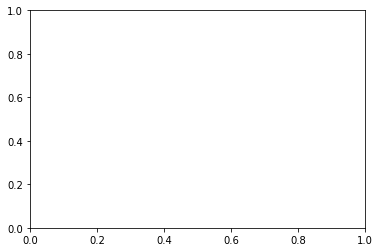

In [21]:
# 데이터 전체(1/27-9/4) 시각화
import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(df)
plt.xticks(rotation=90)
plt.figure(figsize=(200,200))

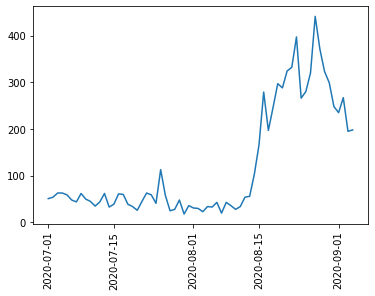

<Figure size 1440x1440 with 0 Axes>

In [20]:
# (7/1-9/4) 시각화
plt.plot(df.iloc[158:,0],df.iloc[158:,1])
plt.xticks(rotation=90)
plt.figure(figsize=(20,20))
plt.show()

-Facebook Prophet 적용하여 예측



In [ ]:
# Facebook Prophet 예측 모델에 넣을 데이터프레임을 만들어준다.
#(날짜는 ds, 다른 변수는 y로 반드시 맞춰준다)
confirmed_prophet = df.rename(columns={'date': 'ds','confirmed': 'y'})
confirmed_prophet.tail()

In [ ]:
#Prophet 객체 생성하고 fit 해준다. 
m=Prophet() 
m.fit(confirmed_prophet)

In [ ]:
#예측할 미래 dataframe 생성해준다. 30일간의 미래 예측해보기
future=m.make_future_dataframe(periods=30)
future
future.tail()
#9월 4일 기준이므로 10월 4일까지의 예측이 가능

In [ ]:
forecast=m.predict(future)
forecast.tail()

In [ ]:
m.plot(forecast)

In [ ]:
#forecast component를 시각화해준다(Trend, Weakly, Yearly)
m.plot_components(forecast)
#trend는 경향성을 보여주고 weekly는 한 주의 일별 경향을 보여준다.

In [6]:
#Prophet에선 기본적으로 트렌드가 변경되는 지점을 자동으로 감지해 트렌드를 예측해준다.
m = Prophet(
    changepoint_prior_scale=0.2, #Change Point의 유연성을 조정하는 방법: 디폴트는 0.05(값이 커질수록 유연해진다)
    changepoint_range=0.9, # 기본적으로 Prophet은 시계열 데이터의 80% 크기에서 잠재적으로 ChangePoint를 지정해주지만 90%로 설정해준다.
    
)

m.fit(confirmed_prophet)

#미래 dataframe
future = m.make_future_dataframe(periods=30)#현재까지의 날짜로부터 30일의 미래
forecast = m.predict(future)

fig = plot_plotly(m, forecast)
py.iplot(fig)

#점이 없이 선만 있는 부분이 예측된 미래  

NameError: name 'Prophet' is not defined

In [ ]:
#checkpoints 나타내기
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
#빨간 점선이 changepoints, 빨간 실선이 Trend를 나타낸다. 

3-2. 사랑제일교회 집단 감염이 일어나지 않았을 시 예측


In [ ]:
# (7/1-8/11) 구간 설정 (8/12 최초 확진자 발생)
ifcon = df[['date','confirmed']][158:200]
ifcon.tail()

In [ ]:
#dataframe값들로 확진자 증감 시도표 그리기
plt.plot(df.iloc[158:200,0],df.iloc[158:200,1])
plt.xticks(rotation=90)
plt.figure(figsize=(200,200))

In [ ]:
#fbprophet을 위한 dataframe
ifcon_prophet = ifcon.rename(columns={'date': 'ds','confirmed': 'y'})
ifcon_prophet.tail()

In [ ]:
#Prophet 객체 생성하고 fit 해준다. 
m=Prophet()
m.fit(ifcon_prophet)

In [ ]:
#예측할 미래 dataframe 만들기(30일)
future=m.make_future_dataframe(periods=30)
future
future.tail()

In [ ]:
##교회 집단감염 전의 데이터에 불확실성을 추가해준다.
#불확실성의 범위 보기
forecast = Prophet(interval_width=0.95).fit(ifcon_prophet).predict(future)
#시즈널리티의 불확실성을 알기 위해 베이지안 샘플링을 사용해야 함,mcmc.samples 파라미터를 사용. 이 값을 사용하면 최초 n일에 대해 적용한다는 뜻
m = Prophet(mcmc_samples=28)
forecast = m.fit(ifcon_prophet).predict(future)
fig = m.plot_components(forecast)
#불투명한 구간이 불확실한 오차구간

In [ ]:
m.plot(forecast)

In [ ]:
#예측모델 시각화
m = Prophet(
    changepoint_prior_scale=0.2, # increasing it will make the trend more flexible 디폴트는 0.05
    changepoint_range=0.9, # place potential changepoints in the first 98% of the time series
    
)

m.fit(ifcon_prophet)

future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)

fig = plot_plotly(m, forecast)
py.iplot(fig)

In [ ]:
#checkpoints 나타내기
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
#빨간 점선이 changepoints, 빨간 실선이 Trend를 나타낸다. 